In [3]:
# Import libraries here
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [4]:
# Load data file

with gzip.open("taiwan-bankruptcy-data.json.gz", "r" ) as f:
    taiwan_data = json.load(f)

print(type(taiwan_data))

<class 'dict'>


In [5]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'metadata', 'observations'])


In [6]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


In [7]:
n_features = len(taiwan_data["observations"][0])
print(n_features)

97


In [8]:
# Create wrangle function
def wrangle(filename):
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    #dict to dataframe, set index
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")
    return df


In [9]:
df = wrangle("taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [10]:
df.isna().columns
df.isna().sum()

,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0
...,...
feat_91,0
feat_92,0
feat_93,0
feat_94,0


In [11]:
nans_by_col = pd.Series( df.isna().sum(),index=df.isna().columns)
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0


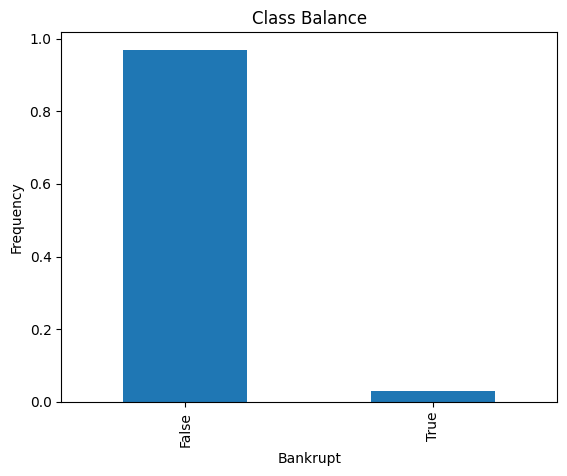

In [12]:
# Plot class balance
df["bankrupt"].value_counts(normalize = True)

fig, ax = plt.subplots()

df["bankrupt"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Bankrupt")
plt.ylabel("Frequency")
plt.title("Class Balance");

In [13]:
#split the dataset
target = "bankrupt"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


In [15]:
#resampling because of imbalance classes
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


In [16]:
#baseline model
acc_baseline = y_train.value_counts(normalize = True)
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: bankrupt
False    0.9688
True     0.0312
Name: proportion, dtype: float64


In [18]:
#Building model - Random forest
clf = RandomForestClassifier(random_state=42)

In [19]:
cv_scores = cross_val_score(clf, X_train_over, y_train_over, n_jobs = -1, cv = 5)
print(cv_scores)

[0.99316868 0.99421965 0.99421661 0.99369085 0.9957939 ]


In [20]:
params_rf = {
    "max_depth": range(30, 50, 10),
    "n_estimators": range(25, 51, 25),
}

In [21]:
model_rf = GridSearchCV(
    clf,
    param_grid= params_rf,
    cv = 5,
    n_jobs = -1,
    verbose= 1
)

In [22]:
model_rf.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(30, 50, 10),
                         'n_estimators': range(25, 51, 25)},
             verbose=1)

In [23]:
cv_results = pd.DataFrame(model_rf.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.096777,0.023121,0.011461,0.001508,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.992643,0.992118,0.991588,0.992639,0.993165,0.992431,0.000536,4
1,2.712240,0.552071,0.017513,0.002023,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.993169,0.993694,0.991588,0.994217,0.994217,0.993377,0.000975,2
2,1.310582,0.368928,0.012339,0.000913,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.992118,0.992643,0.994742,0.992639,0.994217,0.993272,0.001018,3
3,2.057410,0.204273,0.017886,0.003797,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.992643,0.994220,0.994217,0.994742,0.995268,0.994218,0.000878,1


In [24]:
best_params = model_rf.best_params_
print(best_params)

{'max_depth': 40, 'n_estimators': 50}


In [25]:
acc_train = y_train.value_counts(normalize = True).max()
acc_test = y_test.value_counts(normalize = True).max()

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9688
Model Test Accuracy: 0.9699


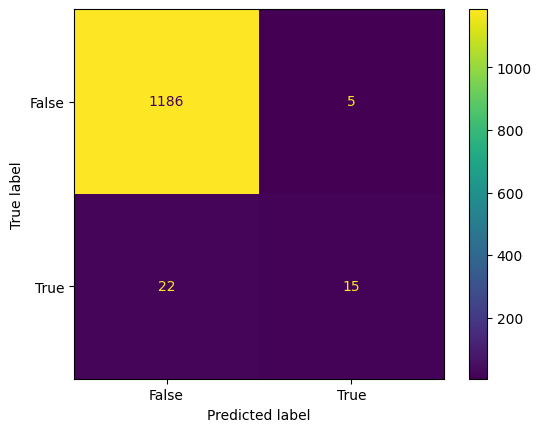

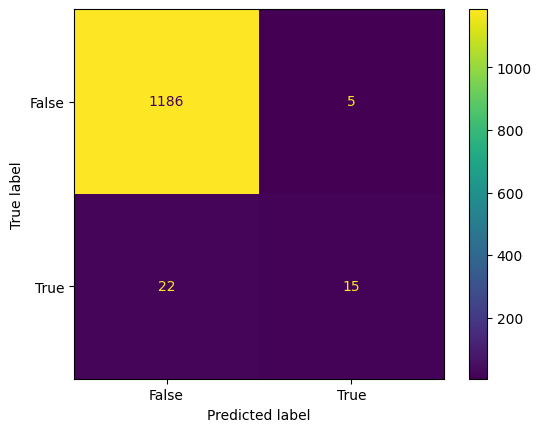

In [26]:
# confusion matrix
y_pred = model_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test)
disp.plot(ax=ax);



In [28]:
# classification report
class_report = classification_report(y_test, model_rf.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1191
        True       0.75      0.41      0.53        37

    accuracy                           0.98      1228
   macro avg       0.87      0.70      0.76      1228
weighted avg       0.97      0.98      0.97      1228



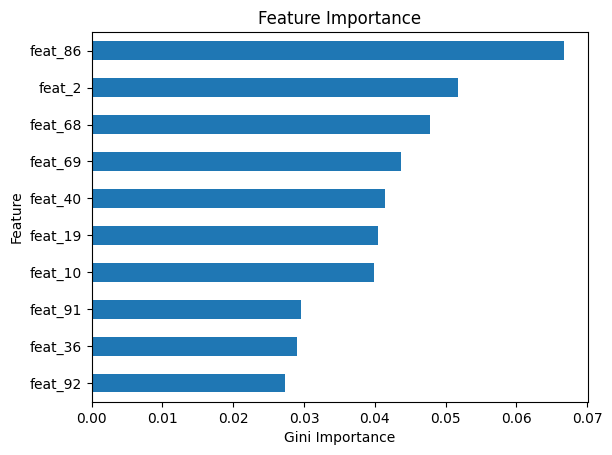

In [29]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model_rf.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = feat_imp = pd.Series(importances, index = features).sort_values()
# Plot 10 most important features

feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [30]:
# Save model
with open("model-rf.pkl", "wb") as f:
    pickle.dump(model_rf, f)

In [33]:
# make prediction
from predictionfunc import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath="model-rf.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


,bankrupt
id,
18,False
20,False
24,False
32,False
38,False
